# Lets make a Choropleth

A choropleth is essentially a data driven map, that changes the map in some regard based on those values.

A very familiar example are the red and blue styles shading of states for US Elections.

## Configure the Map

Maps don't show year over year very well.

To simplify finding this, here is the configuration:

In [1]:
currentYear = 1955;

1955

In [2]:
currentMetric = 'prop';

'prop'

# Datasets

There are a number of datasets you can choose from when trying to render a choropleth, and most depend on:

* the format (ex: shapefile, geojson, topojson)
* the level of detail (ex: 110m has LESS detail than looking at a map at the 10m level)
* the features of data (ex: countries, counties, rivers - and for the right area)

## Natural Earth

[Natural Earth](https://www.naturalearthdata.com/downloads/) is a public domain map dataset available at 1:10m, 1:50m, and 1:110 million scales. Featuring tightly integrated vector and raster data, with Natural Earth you can make a variety of visually pleasing, well-crafted maps with cartography or GIS software.

Natural Earth was built through a collaboration of many volunteers and is supported by NACIS (North American Cartographic Information Society), and is free for use in any type of project ([see their terms of use](https://www.naturalearthdata.com/about/terms-of-use/)).

## TopoJSON

[TopoJSON](https://github.com/topojson/topojson-specification) is an an open format extension from the [GeoJSON](#geojson) format, that can be converted to and from GeoJSON.

TopoJSON has two special caveats over some other GIS formats:

* it can additionally encode non-geographical data
* it eliminates redundancy - resulting in potentially 80% reduction in file sizes.

For example, the shared boundary between California and Nevada is represented only once, rather than being duplicated for both states.

## GapMinder Life Expectancy Study

The [GapMinder Life Expectancy Study](https://www.gapminder.org/answers/how-does-income-relate-to-life-expectancy/) is a facinating dataset and writeup by the GapMinder group, including Professor Hans Rosling.

We'll access this through the [vega-datasets](https://github.com/vega/vega-datasets) library

It provides: 

Property    | Type   | Description
--          | --     | --
year        | Number | The year of the sample
country     | String | Name of the country
pop         | Number | Population of the country
life_expect | Number | Expected Lifespan within that country at that time
fertility   | Number | Reproduction coefficient

**NOTE: the country names are not standardized** - so we'll need to address that.

## Country ISO Codes - 3166

We will use the [i18n-iso-countries](https://www.npmjs.com/package/i18n-iso-countries) library to help us correlate countries by looking them up to the ISO 3166 standard.

[ISO 3166](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes) specifies the Numerical, 2 character and 3 character Country Codes, and will allow us to relate the countries to their geometry.

# Libraries

We will use the following libraries:

In [3]:
utils = require('jupyter-ijavascript-utils');
geographyDatastore = require('sane-topojson');
countryISO = require('i18n-iso-countries');
topojson = require('topojson-client');
['utils', 'geographyDatastore', 'countryCodes', 'topojson'];

[ 'utils', 'geographyDatastore', 'countryCodes', 'topojson' ]

## topojson-client - `topojson`

The [topojson-client](https://github.com/topojson/topojson-client) library provides a way to:

* convert shape / geojson files to and from topojson files
* access geographic features

## sane-topojson - `geographyDatastore`

In our case, we'll be using the [sane-topojson](https://www.npmjs.com/package/sane-topojson) library as it provides a 'cleaned version' of the Natural Earth GIS data that can be accessed directly within node.

(As opposed to the [world-atlas](https://github.com/topojson/world-atlas) library that is only accessible through CDNs)

We'll be using this to:

* access the country geographies that we will render

## i18n-iso-countries - `countryISO`

The [i18n-iso-countries](https://www.npmjs.com/package/i18n-iso-countries) library will allow us to:

* identify 3 character iso codes for country names (joining)
* verify country names that need manual alignment

Next we want to pull the latest gapminder data.

(As an async method, we can use await to fetch the data)

In [4]:
utils.ijs.await(async ($$, console) => {
    gapMinder = await utils.datasets.fetch('gapminder.json');
    return ['gapMinder'];
});

[ 'gapMinder' ]

# Understanding the data

The ultimate goal is to marry the gapMinder data to the geography data.

## GapMinder

First we will want to understand the data in gapMinder:

In [5]:
utils.object.getObjectPropertyTypes(gapMinder)

Map(2) {
  'number' => Set(5) { 'year', 'cluster', 'pop', 'life_expect', 'fertility' },
  'string' => Set(1) { 'country' }
}

Next, let's see which years are available.

In [6]:
utils.agg.unique(gapMinder, 'year');

[
  1955, 1960, 1965,
  1970, 1975, 1980,
  1985, 1990, 1995,
  2000, 2005
]

Next let's see how the data spreads across for those years

In [7]:
utils.group.by(gapMinder, 'year')
    .reduce((recordsWithinYear) => ({ isCountryUnique: utils.aggregate.isUnique(recordsWithinYear, 'country') }));

[
  { year: 1955, isCountryUnique: true },
  { year: 1960, isCountryUnique: true },
  { year: 1965, isCountryUnique: true },
  { year: 1970, isCountryUnique: true },
  { year: 1975, isCountryUnique: true },
  { year: 1980, isCountryUnique: true },
  { year: 1985, isCountryUnique: true },
  { year: 1990, isCountryUnique: true },
  { year: 1995, isCountryUnique: true },
  { year: 2000, isCountryUnique: true },
  { year: 2005, isCountryUnique: true }
]

## Distribution of Countries

So lets take a look at the division of countries:

In [8]:
//-- prints all countries, but harder to read
// utils.group.by(gapMinder, 'year')
//     .reduce((yearRecords) => ({ countries: utils.agg.unique(yearRecords, 'country')}))

utils.group.by(gapMinder, 'year')
     .reduce((yearRecords) => ({ numCountries: utils.agg.unique(yearRecords, 'country').length }))

[
  { year: 1955, numCountries: 63 },
  { year: 1960, numCountries: 63 },
  { year: 1965, numCountries: 63 },
  { year: 1970, numCountries: 63 },
  { year: 1975, numCountries: 63 },
  { year: 1980, numCountries: 63 },
  { year: 1985, numCountries: 63 },
  { year: 1990, numCountries: 63 },
  { year: 1995, numCountries: 63 },
  { year: 2000, numCountries: 63 },
  { year: 2005, numCountries: 63 }
]

How do countries change year over year?

In [9]:
gapMinderCountries = new Set(utils.agg.unique( gapMinder.filter(r => r.year === 1955), 'country'));

utils.group.by(gapMinder, 'year')
    .reduce((yearRecords) => ({
        countriesDiff: utils.aggregate.notIn(
            yearRecords,
            'country',
            gapMinderCountries
        )}))

[
  { year: 1955, countriesDiff: Set(0) {} },
  { year: 1960, countriesDiff: Set(0) {} },
  { year: 1965, countriesDiff: Set(0) {} },
  { year: 1970, countriesDiff: Set(0) {} },
  { year: 1975, countriesDiff: Set(0) {} },
  { year: 1980, countriesDiff: Set(0) {} },
  { year: 1985, countriesDiff: Set(0) {} },
  { year: 1990, countriesDiff: Set(0) {} },
  { year: 1995, countriesDiff: Set(0) {} },
  { year: 2000, countriesDiff: Set(0) {} },
  { year: 2005, countriesDiff: Set(0) {} }
]

Looks like the same countries are available every year

# Translate Countries to ISO Codes

So ultimately we need to translate the countries in the GapMinder set to those supported by the map

(We'll come back to this under the [WorldGeography Organization - geographyDatastore section](#World-Geography-organization---geographyDatastore) below)

In [10]:
topojson.feature(geographyDatastore.world_50m, 'countries').features.map(r => r.id)

[
  'ZWE', 'ZMB', 'YEM', 'VNM', 'VEN',     'VAT',
  'VUT', 'UZB', 'URY', 'FSM', 'MHL',     'MNP',
  'VIR', 'GUM', 'ASM', 'PRI', 'USA',     'SGS',
  'IOT', 'SHN', 'PCN', 'AIA', 'FLK',     'CYM',
  'BMU', 'VGB', 'TCA', 'MSR', 'JEY',     'GGY',
  'IMN', 'GBR', 'ARE', 'UKR', 'UGA',     'TKM',
  'TUR', 'TUN', 'TTO', 'TON', 'TGO',     'TLS',
  'THA', 'TZA', 'TJK', 'TWN', 'SYR',     'CHE',
  'SWE', 'SWZ', 'SUR', 'SSD', 'SDN',     'LKA',
  'ESP', 'KOR', 'ZAF', 'SOM', undefined, 'SLB',
  'SVK', 'SVN', 'SGP', 'SLE', 'SYC',     'SRB',
  'SEN', 'SAU', 'STP', 'SMR', 'WSM',     'VCT',
  'LCA', 'KNA', 'RWA', 'RUS', 'ROU',     'QAT',
  'PRT', 'POL', 'PHL', 'PER', 'PRY',     'PNG',
  'PAN', 'PLW', 'PAK', 'OMN', 'NOR',     'PRK',
  'NGA', 'NER', 'NIC', 'NZL', 'NIU',     'COK',
  'NLD', 'ABW', 'CUW', 'NPL',
  ... 141 more items
]

## Country Codes

In particular - notice the `id` field under the feature,
in this case they are the [iso 3166 standard of country codes](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes)

For example:

Country name                            |Official state name             |Sovereignty|Alpha-2 code|Alpha-3 code|Numeric code|Subdivision code links|Internet ccTLD
--                                         |--                                 |--                  |--             |--             |--             |--                       |--               
Islamic Republic of Afghanistan Afghanistan|The Islamic Republic of Afghanistan|UN member state     |AF             |AFG            |004            |ISO 3166-2:AF            |.af 

Notice there are three main codes to understand:

* Alpaa-3 Code - a 3 letter code for the country - ex: 'AFG'
* Alpha-2 Code - a 2 letter code for the country - ex: 'AF'
* Numeric Code - a numeric code for the country - ex: '004' or just '4'

In the case for `sane-topojson`, it uses the three letter `Alpha-3 code`, with other cases like the [topojson/topojson](https://github.com/topojson/topojson) library, uses the Numeric code instead.

In [11]:
utils.array.peekFirst(gapMinder).country;

'Afghanistan'

We can translate that through `countryISO.getSimpleAlpha3Code(countryName, supportedLanguage)`

In [12]:
countryISO.getSimpleAlpha3Code(
    utils.array.peekFirst(gapMinder).country,
    'en'
)

'AFG'

Are there any countries that cannot be translated?

In [13]:
countriesToTranslateManually = [...gapMinderCountries].filter(
    //-- find the ones where there is no iso translation
    (gapMinderCountryName) => !countryISO.getSimpleAlpha3Code(gapMinderCountryName, 'en')
);

[]

Looks like all countries can be translated to ISO

In [14]:
gapMinder = gapMinder.map((record) => ({
    ...record,
    //-- add on the property countryISO 
    countryISO: countryISO.getSimpleAlpha3Code(record.country, 'en')
}));

utils.array.peekFirst(gapMinder);

{
  year: 1955,
  country: 'Afghanistan',
  cluster: 0,
  pop: 8891209,
  life_expect: 30.332,
  fertility: 7.7,
  countryISO: 'AFG'
}

Looks like they all were assigned, lets just verify they were all translated:

In [15]:
gapMinder.filter(r => !r.countryISO)

[]

In [16]:
// utils.ijs.markdown(`
console.log(`
## World Geography organization - geographyDatastore

Now, lets look at the geography data available.

The data for \`sane-topojson\` is stored is as follows:

* \[top level\]
  * document
    * feature
      * geometries

### Document

Where the documents can be found by Object.keys(atlas) and are as follows:

\`${Object.keys(geographyDatastore).join(', ')}\`

Each representing a dataset (like the world or asia) and the detail level (50m having more detail than at 110m for example)

`);


## World Geography organization - geographyDatastore

Now, lets look at the geography data available.

The data for `sane-topojson` is stored is as follows:

* [top level]
  * document
    * feature
      * geometries

### Document

Where the documents can be found by Object.keys(atlas) and are as follows:

`world_110m, world_50m, africa_110m, africa_50m, asia_110m, asia_50m, europe_110m, europe_50m, north-america_110m, north-america_50m, south-america_110m, south-america_50m, usa_110m, usa_50m`

Each representing a dataset (like the world or asia) and the detail level (50m having more detail than at 110m for example)




### Features Available

The Features available are under \`geographyDatastore.[document].objects.[feature name]\`

Different documents can have different features available.

In the case of the \`sane-topojson\`, this is the breakdown
(it seems fairly even across)

In [17]:
new utils.TableGenerator(
    Object.keys(geographyDatastore).map((documentName) => ({
        document: documentName,
        featuresSupported: Object.keys(geographyDatastore[documentName].objects)
    }))
)
    .render()

document 
 featuresSupported 
 
 
 world_110m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 world_50m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 africa_110m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 africa_50m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 asia_110m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 asia_50m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 europe_110m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 europe_50m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 north-america_110m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 north-america_50m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 south-america_110m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 south-america_50m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 usa_110m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"] 
 
 
 usa_50m 
 ["coastlines","land","ocean","lakes","rivers","countries","subunits"]

## Countries

However, instead of accessing directly, we would recommend you use the "topojson" library to access these feature:

ex: topojson.feature(atlas.world_50m, 'countries')

That looks like this:

In [18]:
console.log(
utils.format.ellipsify(
    `topojson.feature(geographyDatastore.world_50m, 'countries'):\n` +
    JSON.stringify(
        topojson.feature(geographyDatastore.world_50m, 'countries'), null, 2
    ), 500
)
)

topojson.feature(geographyDatastore.world_50m, 'countries'):
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "id": "ZWE",
      "properties": {
        "ct": [
          29.85,
          -19
        ]
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              31.305130513051324,
              -22.402569514763996
            ],
            [
              31.197119711971197,
              -22.34856…


## Making a simple Map

We can use the geography data to create a simple map

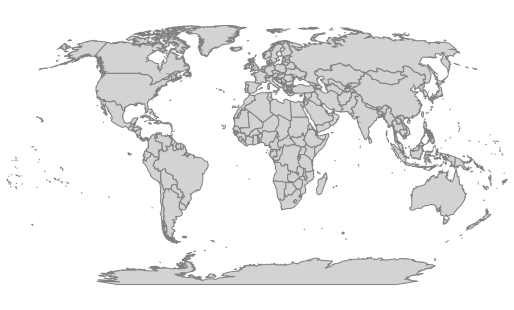

In [19]:
utils.vega.svgFromSpec({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "width": 500,
  "height": 300,
  "data": {
    values: geographyDatastore.world_50m,
    //-- note the feature is specific to countries - one of the features of the dataset.
    "format": {"type": "topojson", "feature": "countries"}
  },
  //-- projection type from one of the following:
  "projection": {"type": 'naturalEarth1'},
  "mark": {"type": "geoshape", "fill": "lightgray", "stroke": "gray"}
});

//-- other projection types:
// albers,albersUsa,azimuthalEqualArea,azimuthalEquidistant,conicConformal,
// conicEqualArea,conicEquidistant,equalEarth,equirectangular,gnomonic,mercator,
// naturalEarth1,orthographic,stereographic,transverseMercator

What we want to do is change the color of the country based on the metric.

# Map Countries by ISO 3166 Code

In our case, the 'id' property on those features gives us the `ISO 3166 - 3 Alpha` code for the country

In [20]:
topojson.feature(geographyDatastore.world_50m, 'countries').features.map(r => r.id)

[
  'ZWE', 'ZMB', 'YEM', 'VNM', 'VEN',     'VAT',
  'VUT', 'UZB', 'URY', 'FSM', 'MHL',     'MNP',
  'VIR', 'GUM', 'ASM', 'PRI', 'USA',     'SGS',
  'IOT', 'SHN', 'PCN', 'AIA', 'FLK',     'CYM',
  'BMU', 'VGB', 'TCA', 'MSR', 'JEY',     'GGY',
  'IMN', 'GBR', 'ARE', 'UKR', 'UGA',     'TKM',
  'TUR', 'TUN', 'TTO', 'TON', 'TGO',     'TLS',
  'THA', 'TZA', 'TJK', 'TWN', 'SYR',     'CHE',
  'SWE', 'SWZ', 'SUR', 'SSD', 'SDN',     'LKA',
  'ESP', 'KOR', 'ZAF', 'SOM', undefined, 'SLB',
  'SVK', 'SVN', 'SGP', 'SLE', 'SYC',     'SRB',
  'SEN', 'SAU', 'STP', 'SMR', 'WSM',     'VCT',
  'LCA', 'KNA', 'RWA', 'RUS', 'ROU',     'QAT',
  'PRT', 'POL', 'PHL', 'PER', 'PRY',     'PNG',
  'PAN', 'PLW', 'PAK', 'OMN', 'NOR',     'PRK',
  'NGA', 'NER', 'NIC', 'NZL', 'NIU',     'COK',
  'NLD', 'ABW', 'CUW', 'NPL',
  ... 141 more items
]

We want to append the `properties` object for those countries to include the gapMinder data

In [21]:
topojson.feature(geographyDatastore.world_50m, 'countries').features.filter(feature => !countryISO.isValid(feature.id))

[
  {
    type: 'Feature',
    properties: {},
    geometry: { type: 'Polygon', coordinates: [Array] }
  },
  {
    type: 'Feature',
    properties: {},
    geometry: { type: 'Polygon', coordinates: [Array] }
  },
  {
    type: 'Feature',
    properties: {},
    geometry: { type: 'Polygon', coordinates: [Array] }
  },
  {
    type: 'Feature',
    properties: {},
    geometry: { type: 'MultiPolygon', coordinates: [Array] }
  },
  {
    type: 'Feature',
    properties: {},
    geometry: { type: 'Polygon', coordinates: [Array] }
  },
  {
    type: 'Feature',
    properties: {},
    geometry: { type: 'Polygon', coordinates: [Array] }
  }
]

In [22]:
countriesWithIsoCode = topojson.feature(geographyDatastore.world_50m, 'countries').features
    .filter((feature) => feature.id);
countriesWithIsoCode.length;

235

Let's make a map of the countries by their isoCode

In [23]:
countriesByIsoCode = utils.group.index(
    countriesWithIsoCode, 'id'
)
countriesByIsoCode.size

235

## Verify GapMinder Aligns to Countries

Now, lets verify  the gapMinder data to those countries

Lets make a set of the iso codes from within the geography

In [24]:
geographyCountryIsoCodes = new Set(Array.from(countriesByIsoCode.values()).map(r => r.id));
geographyCountryIsoCodes.size

235

And a set of the iso codes from within gap minder

In [25]:
gapMinderIsoCodes = new Set(utils.aggregate.unique(gapMinder, 'countryISO'));
gapMinderIsoCodes.size

63

and see if there are any iso codes we use in gap minder that are not found:

In [26]:
utils.set.findItemsNotContained(geographyCountryIsoCodes, gapMinderIsoCodes);

Set(0) {}

Lastly, are there any gapMinder records that do not map to any country?

In [27]:
gapMinder.filter((gapMinderRecord) => {
    const countryISO = gapMinderRecord.countryISO;
    const countryGeography = countriesByIsoCode.get(countryISO);
    return !countryGeography
})

[]

Nope. Looks like we're good to go.

### 110m vs 50m level countries

**NOTE: that the number of countires DOES change at the 110m vs the 50m size**

In [28]:
countryCodes110m = new Set(
    topojson.feature(geographyDatastore.world_110m, 'countries').features.map(feature => feature.id)
);

utils.set.findItemsNotContained(geographyCountryIsoCodes, countryCodes110m);

Set(1) { undefined }

There are some countries at the 110m level that DO NOT have an id

In [29]:
topojson.feature(geographyDatastore.world_110m, 'countries').features.filter(feature => !feature.id).length

3

And there are 63 countries at the 50m level NOT in the 110m level

In [30]:
Array.from(
    utils.set.findItemsNotContained(countryCodes110m, geographyCountryIsoCodes)
)

[
  'VAT', 'FSM', 'MHL', 'MNP', 'VIR', 'GUM',
  'ASM', 'SGS', 'IOT', 'SHN', 'PCN', 'AIA',
  'CYM', 'BMU', 'VGB', 'TCA', 'MSR', 'JEY',
  'GGY', 'IMN', 'TON', 'SGP', 'SYC', 'STP',
  'SMR', 'WSM', 'VCT', 'LCA', 'KNA', 'PLW',
  'NIU', 'COK', 'ABW', 'CUW', 'NRU', 'MCO',
  'MUS', 'MLT', 'MDV', 'LIE', 'KIR', 'GRD',
  'SPM', 'WLF', 'MAF', 'BLM', 'PYF', 'ALA',
  'DMA', 'FRO', 'COM', 'MAC', 'HKG', 'CPV',
  'BRB', 'BHR', 'HMD', 'NFK', 'ATG', 'AND',
  'SXM'
]

# Making maps

As a refresher, we can make a simple map like so:

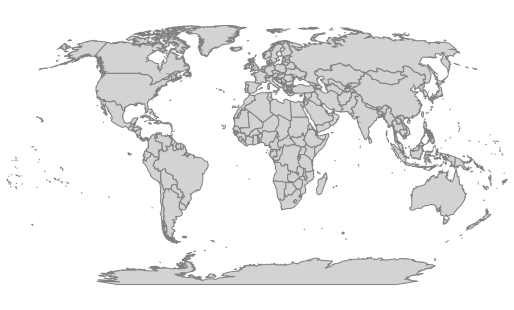

In [31]:
utils.vega.svgFromSpec({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "width": 500,
  "height": 300,
  "data": {
    values: geographyDatastore.world_50m,
    //-- note the feature is specific to countries - one of the features of the dataset.
    "format": {"type": "topojson", "feature": "countries"}
  },
  //-- projection type from one of the following:
  "projection": {"type": 'naturalEarth1'},
  "mark": {"type": "geoshape", "fill": "lightgray", "stroke": "gray"}
});

//-- other projection types:
// albers,albersUsa,azimuthalEqualArea,azimuthalEquidistant,conicConformal,
// conicEqualArea,conicEquidistant,equalEarth,equirectangular,gnomonic,mercator,
// naturalEarth1,orthographic,stereographic,transverseMercator

## Merge the Data

For simplicity's sake, we will update the records on the Geography to have a `mapValue` property.

(There are ways to do the transformations within Vega, but they are complex and difficult to troubleshoot,
so we will handle them in a different doc, with an example below just for demonstration).

### Transformation function

Function that determines a metric for a given year and countryISO code

In [32]:
getCountryValue = (metric, year, countryISO) => utils.array.peekFirst(
        gapMinder.filter((r) => r.year === year && r.countryISO === countryISO),
        {}
    )[metric];

[Function: getCountryValue]

Let's verify it gets us a value for a specific year and date

In [33]:
getCountryValue('life_expect', 1955, 'AFG');

30.332

Next, lets verify the value returns null, if the record cannot be found

In [34]:
getCountryValue('life_expect', 1955, null) === null

false

## Create the Choropleth Data

Now let's create a specific version of the data we can use for charting.

(Note - in an immutable manner to avoid race conditions between cells)

In [35]:
generateMapData = (metric, year) => topojson.feature(geographyDatastore.world_50m, 'countries')
    .features
    .map((entry) => ({ mapValue: getCountryValue(metric, year, entry.id), ...entry }));

[Function: generateMapData]

Then we check if it worked

In [36]:
utils.array.peekFirst(gapMinder)

{
  year: 1955,
  country: 'Afghanistan',
  cluster: 0,
  pop: 8891209,
  life_expect: 30.332,
  fertility: 7.7,
  countryISO: 'AFG'
}

and then check the country for that year

In [37]:
generateMapData('pop', 1955)
    .filter(entry => entry.id === 'AFG')

[
  {
    mapValue: 8891209,
    type: 'Feature',
    id: 'AFG',
    properties: { ct: [Array] },
    geometry: { type: 'Polygon', coordinates: [Array] }
  }
]

It looks like the two numbers match, so let's run the chart.

## Create the Choropleth

We can create the map for each of the countries that have values, and for a specific year.

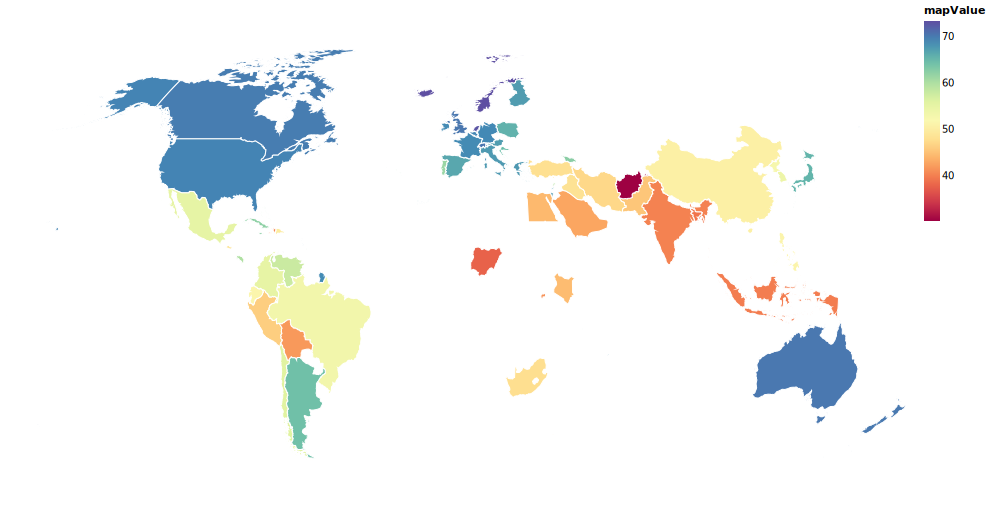

In [38]:
utils.vega.svgFromSpec({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "mark": {
    "type": "geoshape",
    "stroke": "white"
  },
  "data": {
      "values": generateMapData('life_expect', 1955)
  },
  "encoding": {
    "color": {
      "field": "mapValue",
      "type": "quantitative",
      "scale": {
        "scheme": "spectral"
      }
    }
  },
  "projection": {
    "type": "naturalEarth1",
  },
  "width": 900,
  "height": 500
});

## Why are the other countries missing?
    
Vega-Lite removes records with null values. [See issue #3261 for more](https://github.com/vega/vega-lite/issues/3261)
                                                                       
We want instead to show those countries, but have then show up as grey.
                                                                       
To show the null values you must add in the following `config`:

```
  "config": {
    "mark": {"invalid": null}
  }
```

We also want to show the null values as our own color of our choosing,
so we add a conditional to explicitly set the color:

```
{ "condition": {
    "test": { not: "isDefined(datum.mapValue)" },
    "value": "darkgrey"
}
```

Changing the `color` attribute to:

```
    "color": {
      "condition": {
        "test": { not: "isDefined(datum.mapValue)" },
        "value": "darkgrey"
      },
      "field": "mapValue",
      "type": "quantitative",
      "scale": {
        "scheme": "spectral"
      }
    }
```

With the full spec as follows:

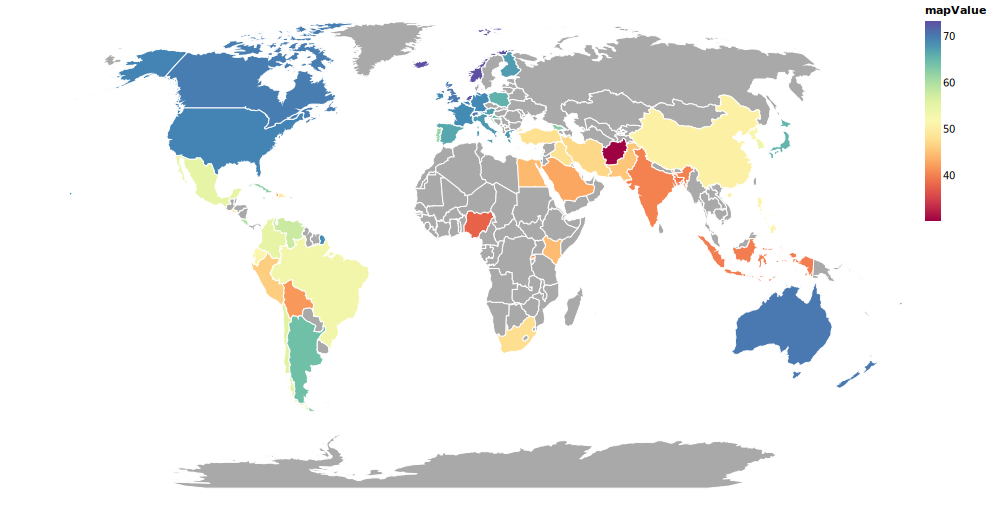

In [39]:
utils.vega.svgFromSpec({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "mark": {
    "type": "geoshape",
    "stroke": "white"
  },
  "data": {
      "values": generateMapData('life_expect', 1955)
  },
  "encoding": {
    "color": {
      "condition": {
        "test": { not: "isDefined(datum.mapValue)" },
        "value": "darkgrey"
      },
      "field": "mapValue",
      "type": "quantitative",
      "scale": {
        "scheme": "spectral"
      }
    }
  },
  "projection": {
    "type": "naturalEarth1",
  },
  "width": 900,
  "height": 500,
  "config": {
    "mark": {"invalid": null}
  }
});

# Bonus

@TODO

While we said we wouldn't get into it further in this document,
here is an example that instead aligns the gapMinder values within the Vega-Lite specification:

* data of the geographyStore is loaded the same as above
* it is then transformed through the [lookup](https://vega.github.io/vega-lite-v3/docs/lookup.html)
  * copying the `life_expect`, `pop` and `fertility` fields over
* the field we want can be 'parameterized' under params as the 'chartField' variable
* we then calculate a new value called `chartValue` based on the param
* default colors are set the same as above

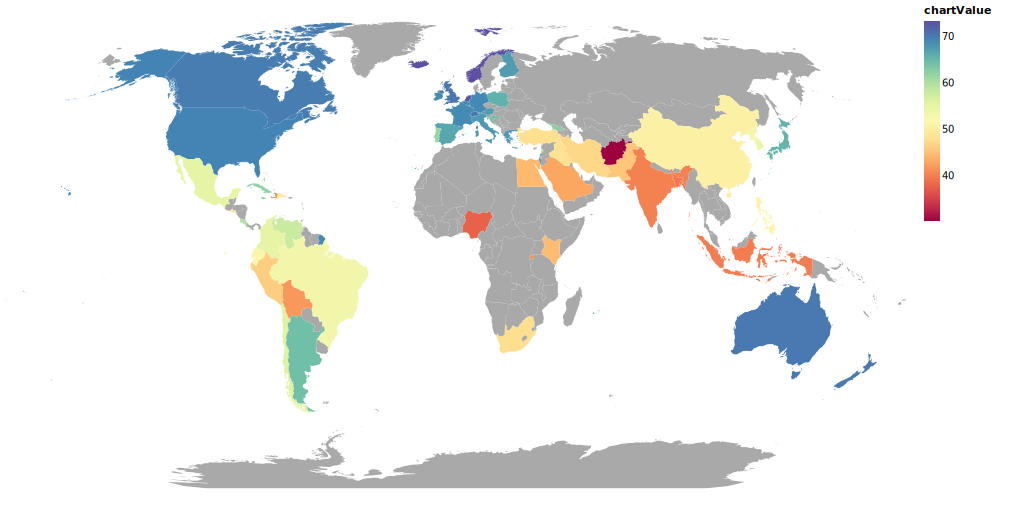

In [40]:
utils.vega.svgFromSpec({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "params": [
    { "name": "chartField", "value": "life_expect"}
  ],
  "width": 900,
  "height": 500,
  "data": {
    // "url": "https://vega.github.io/vega-lite/examples/data/us-10m.json",
    "values": geographyDatastore.world_50m,
    "format": {
      "type": "topojson",
      "feature": "countries"
    }
  },

  "transform": [{
    "type": "lookup",
    "lookup": "id",
    "from": {
      "data": {
        "values": gapMinder.filter(r => r.year === 1955)
      },
      "fields": ["life_expect", "pop", "fertility"],
      "key": "countryISO"
    }
  },
  {
    "calculate": "datum[chartField]",
    "as": "chartValue",
  }],
  "projection": {
    "type": "naturalEarth1"
  },
  "mark": "geoshape",
  "encoding": {
    "color": {
      "condition": {
        "test": "datum.chartValue === null",
        "value": "darkgrey"
      },
      "field": "chartValue",
      "type": "quantitative",
      "scale": {
        "scheme": "spectral"
      },
    }
  },
  "config": {
    "mark": {"invalid": null}
  }
});

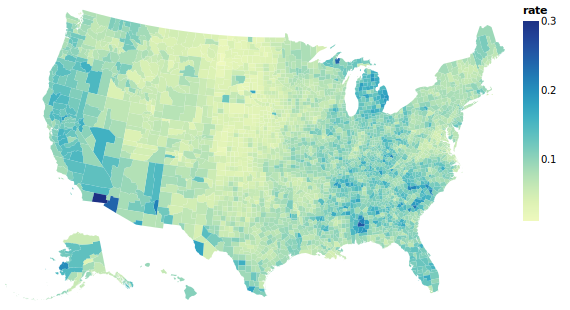

In [41]:
utils.vega.svgFromSpec({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "width": 500,
  "height": 300,
  "data": {
    "url": "https://vega.github.io/vega-lite/examples/data/us-10m.json",
    "format": {
      "type": "topojson",
      "feature": "counties"
    }
  },
  "transform": [{
    "lookup": "id",
    "from": {
      "data": {
        "url": "https://vega.github.io/vega-lite/examples/data/unemployment.tsv"
      },
      "key": "id",
      "fields": ["rate"]
    }
  }],
  "projection": {
    "type": "albersUsa"
  },
  "mark": "geoshape",
  "encoding": {
    "color": {
      "field": "rate",
      "type": "quantitative"
    }
  }
});


# Appendix

## Other Formats

### ShapeFile

One of the more heavily standardized formats are ShapeFiles - meant as a way to spacially describe vector features: points, lines, and polygons, representing, for example, water wells, rivers, and lakes. Each item usually has attributes that describe it, such as name or temperature. The format is meant to provide a standard for interoperability between ESRI systems and other GIS software.

The [ShapeFile](https://en.wikipedia.org/wiki/Shapefile) format is a semi-open standard designed and regulated by [Environmental Systems Research Institute - ESRI](https://en.wikipedia.org/wiki/Esri) - an international supplier of [GIS - GeoCoded data](https://en.wikipedia.org/wiki/Geographic_information_system).

### GeoJSON

An alternative format is [GeoJSON](https://geojson.org/) is an [open standard format - rfc7946](https://tools.ietf.org/html/rfc7946) designed for representing simple geographical features, along with their non-spatial attributes and is based on the JSON format.

Various providers, like [Natural Earth](https://www.naturalearthdata.com/) 